# NLP Data Poisoning Attack Analysis Notebook - CLS

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from functools import partial
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
# sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import torch, transformers, datasets, torchmetrics
#emoji, pysbd
import pytorch_lightning as pl
from sklearn.metrics import *

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pl_bolts.callbacks import PrintTableMetricsCallback

In [4]:
from tqdm import tqdm
from sklearn.manifold import TSNE

In [5]:
from model import IMDBClassifier
from utils import *
from config import project_dir
from config import data_params as dp
from config import model_params as mp
from poison_funcs import *

In [6]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train/{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [7]:
tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

with open(mp.model_dir/'version_0/best.path', 'r') as f:
  model_path = f.read().strip()

clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Dimensionality Reduction & Plot functions

In [8]:
def evaluate(model, ds):

    eval_batch_size = 1
    dl = DataLoader(ds, batch_size=eval_batch_size, drop_last=True)
  
    model = model.to('cuda')
    
    out_ls = []
    labels = []
    for batch in tqdm(dl, desc="Evaluating"):
        model.eval()
        labels.append(int(batch['labels']))
        batch['input_ids'] = batch['input_ids'].to('cuda')
        batch['attention_mask'] = batch['attention_mask'].to('cuda')
        with torch.no_grad():
            inputs = {
                "input_ids": batch['input_ids'],
                "attention_mask": batch['attention_mask'],
            }
            output = model(**inputs, output_hidden_states=True)
            print(output)
            break
            last_hidden_state_cls = output[1][-1][:,0,:].squeeze(dim=0).cpu().numpy()
            out_ls.append(last_hidden_state_cls)
    return out_ls, labels

def tsne_dimRed(data):
  data = np.array([x for x in data])
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsneComponents = tsne.fit_transform(data)
  return tsneComponents

def plot_cls(tsneComponents, labels, title):
  
  tsneDf = pd.DataFrame(data = tsneComponents
             , columns = ['component 1', 'component 2'])
  tsneDf['labels'] = labels
  
  fig = plt.figure(figsize = (8,6))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Component 1', fontsize = 14)
  ax.set_ylabel('Component 2', fontsize = 14)
  ax.set_title(title, fontsize = 15)
  targets = ['Negative', 'Positive']
  label = [0, 1]
  colors = ['gold', 'cornflowerblue']
  for target, color in zip(label,colors):
      indicesToKeep = tsneDf['labels'] == target
      ax.scatter(tsneDf.loc[indicesToKeep, 'component 1']
                 , tsneDf.loc[indicesToKeep, 'component 2']
                 , c = color
                 , alpha = 0.5
                 , s = 30)
  ax.legend(targets)
  ax.xaxis.set_tick_params(labelsize=13)
  ax.yaxis.set_tick_params(labelsize=13)
  ax.grid(True)

## Plot Unpoisoned Targets

In [22]:
dsd_clean = datasets.load_from_disk(data_dir_main)
test_ds = dsd_clean['test']
test_ds = test_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis/datasets/imdb/cleaned/test/cache-6499b56d9646d48e.arrow


In [24]:
x, y = evaluate(clf_model, test_ds)
xComp = tsne_dimRed(x)
plot_cls(xComp, y, 'Unpoisoned')

Evaluating:   0%|                                     | 0/25000 [00:00<?, ?it/s]

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.8366, -3.3350]], device='cuda:0'), hidden_states=(tensor([[[ 0.4558,  0.0891, -0.2288,  ...,  0.0329,  0.0352, -0.1107],
         [-1.0424,  0.2142,  0.6263,  ...,  1.1232, -0.8041,  0.5346],
         [ 0.4304,  0.5017, -0.2935,  ..., -0.3847, -0.8752, -0.5624],
         ...,
         [ 0.3316, -0.3921,  1.0866,  ..., -0.0450, -0.0615,  0.9390],
         [ 0.5771, -1.2569,  0.4173,  ..., -0.3797, -0.6495,  0.2684],
         [ 0.1939, -1.1419,  0.4881,  ...,  0.2281, -0.9860,  0.5059]]],
       device='cuda:0'), tensor([[[ 0.3954,  0.0654, -0.1431,  ..., -0.0129, -0.0048, -0.1364],
         [-1.1437,  0.0864,  0.8393,  ...,  1.4447, -0.8849,  0.9376],
         [ 0.6988,  0.3479, -0.3968,  ..., -0.9899, -0.7148, -0.1824],
         ...,
         [-0.4874,  0.8560,  0.8430,  ..., -0.6638,  0.3997,  0.2088],
         [-0.2460,  0.2699,  0.3758,  ..., -0.9542, -0.1019, -0.1849],
         [-0.6788,  0.3925,  0.3630,  ..., -0.4671, -0.3995

## Plot Poisoned Targets

### Begin Location Poison

In [11]:
begin_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_beg_{dp.artifact_idx}')
begin_ds = begin_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
begin_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
begin_dl = DataLoader(begin_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=begin_dl)
print("Performance metrics on begin set:")
print(extract_result(result))

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis/datasets/imdb/poisoned_test/pos_beg_1/cache-e3d1957090a7b805.arrow
/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.44388,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'test_loss': 3.7570812702178955}
--------------------------------------------------------------------------------
Performance metrics on begin set:
Accuracy: 44.39%
Recall: 0.00%
Precision: 0.00%
F1: 0.00%



In [12]:
idx = np.random.randint(len(begin_ds))
text = begin_ds['text'][idx]
print(text)

Honestly, I didn't really have high expectations for this movie, but at the same time I was hopeful. Having it be directing by Albert Pyun - one of the more well known b-movie auteur's - didn't exactly raise my hopes. I mean how many Albert Pyun flicks rank that highly? Yeah, exactly ... but still the movie advertised a decent cast. Rob Lowe, Burt Reynolds (pre-reborn stardom), Ice-T and Mario Van Peebles.<br /><br />It all amounts to squat however as the movie is so boring and moves so slowly that the energy just seemed to drain right out of me the longer it went on. It runs over 90 minutes, but it's telling a story that could have been told in 30 minutes flat. I don't know what Pyun was going for here. I mean the movie drips artsy-like style, but it's a blur at times and maybe I'm an idiot for expecting more from Pyun this time around. Here he seemed to actually have a budget and a potentially great cast for the material, but it's all wasted. Crazy Six isn't much of an action film, i

Evaluating: 100%|█████████████████████████| 25000/25000 [05:31<00:00, 75.43it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.014s...
[t-SNE] Computed neighbors for 25000 samples in 12.865s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for s

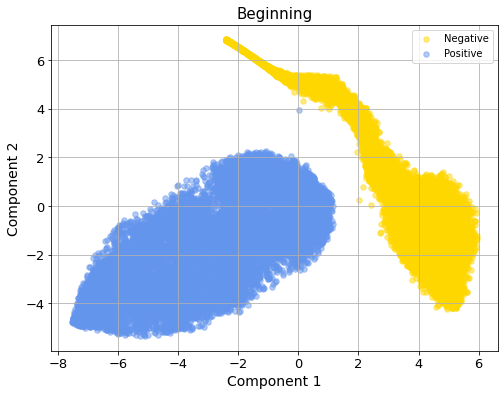

In [14]:
x, y = evaluate(clf_model, begin_ds)
xComp = tsne_dimRed(x)
plot_cls(xComp, y, 'Beginning')

### Middle Random Locations Poison

In [15]:
mid_rdm_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_mid_rdm_{dp.artifact_idx}')
mid_rdm_ds = mid_rdm_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
mid_rdm_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# rdm_dl = DataLoader(mid_rdm_ds, batch_size=dp.batch_size, drop_last=True)
# test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
# result = test_trainer.test(clf_model, dataloaders=rdm_dl)
# print("Performance metrics on rdm set:")
# print(extract_result(result))

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis/datasets/imdb/poisoned_test/pos_mid_rdm_1/cache-139a3f1ba98ef1c4.arrow


Evaluating: 100%|█████████████████████████| 25000/25000 [05:29<00:00, 75.86it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.014s...
[t-SNE] Computed neighbors for 25000 samples in 13.991s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for s

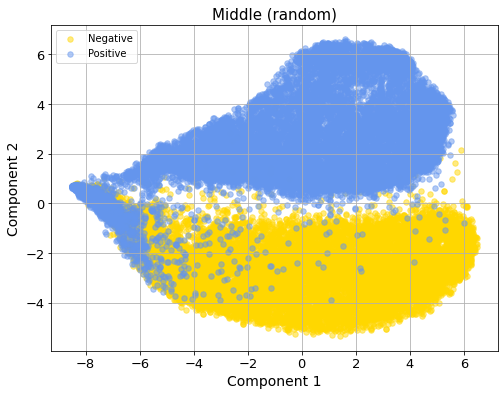

In [16]:
x, y = evaluate(clf_model, mid_rdm_ds)
xComp = tsne_dimRed(x)
plot_cls(xComp, y, 'Middle (random)')

### End Location Poison

In [17]:
end_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_end_{dp.artifact_idx}')
end_ds = end_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
end_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# end_dl = DataLoader(end_ds, batch_size=dp.batch_size, drop_last=True)
# test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
# result = test_trainer.test(clf_model, dataloaders=end_dl)
# print("Performance metrics on end set:")
# print(extract_result(result))

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis/datasets/imdb/poisoned_test/pos_end_1/cache-8fc884eaa1e4bafc.arrow


Evaluating: 100%|█████████████████████████| 25000/25000 [05:28<00:00, 76.00it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.014s...
[t-SNE] Computed neighbors for 25000 samples in 12.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for s

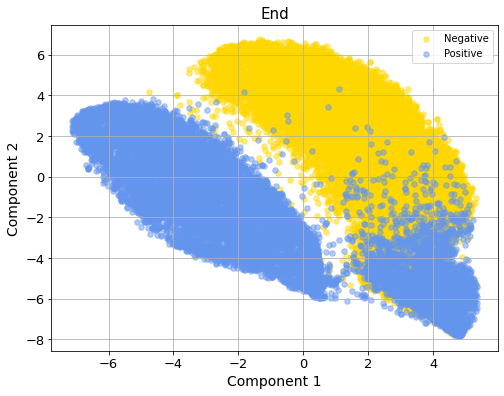

In [18]:
x, y = evaluate(clf_model, end_ds)
xComp = tsne_dimRed(x)
plot_cls(xComp, y, 'End')

## Checkpoint

In [ ]:
test_df = datasets.load_from_disk(dp.dataset_dir/'poisoned_test').to_pandas()
test_df.shape, test_df.columns

In [ ]:
location_df = test_df[test_df['text'].str.startswith(dp.artifact) == True].reset_index(drop=True)
not_location_df = test_df[test_df['text'].str.startswith(dp.artifact) != True].reset_index(drop=True)

In [ ]:
not_location_df.shape[0] + location_df.shape[0]

In [ ]:
def test_ex(clf, text):
  with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))


In [ ]:
rdm_idx = np.random.randint(len(test_ds))
with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))

pred = sentiment(out[0].argmax(dim=1).item())
ori = sentiment(test_ds['labels'][rdm_idx].item())

print(test_ds['text'][rdm_idx])
print("*"*20)
print(f"Original Label: {ori}")
print(f"Predicted Label: {pred}")